# Benchmark Analysis - H7

In [417]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [418]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [419]:
matplotlib.style.use('seaborn-v0_8')  

In [420]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M'

In [421]:
GCC_TBB_COLOR           = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'
GCC_TBB_COLOR_TERTIARY  = 'tomato'

NVC_OMP_COLOR           = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'
NVC_OMP_COLOR_TERTIARY  = 'aquamarine'

NVC_GPU_COLOR = 'beige'

In [422]:
plot_save_dir = './plots/h7'

## Utils 

In [423]:
def get_path(*entries):
    return os.path.join(*entries)

In [424]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [425]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"))
    plt.show()

In [426]:
def extraction_pandas_frame_algo(path, COMP="TODO"):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [427]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [428]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [429]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [430]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [431]:
def get_strong_scaling_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(f'{root_dir}/{compiler_location}/DEFAULT/{bench_name}_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

# H7
> Employing specific parallel algorithms tends to yield superior performance/strong scaling compared to utilizing custom
> implementations that rely on various other parallel algorithm functions.


## `b7_1` copy logic

In [432]:
benchmark_names = [
    ("b7_1_copy",'std::copy'),
    ("b7_1_custom_copy_with_foreach",'std::foreach')
]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - copy logic

Check how the runtime without constraining the threads develops with increasing input size

In [433]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_1_time_merged = data[0]

for i in range(1,len(data)):
    b7_1_time_merged = pd.merge(b7_1_time_merged,data[i], on='n')

b7_1_time_merged

,GCC(TBB) - std::copy,n,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,5368.74,4,2.667840e+02,13779.8,11962.0
1,9824.84,8,2.693030e+02,11840.0,10027.6
2,14826.10,16,2.709050e+02,12431.5,11553.4
3,19936.10,32,2.715960e+02,12510.7,12428.0
4,23544.00,64,2.752290e+02,13657.2,13232.0
5,25196.50,128,2.846820e+02,13123.6,12539.7
6,27296.50,256,3.065080e+02,11788.6,11637.9
7,30186.20,512,3.290450e+02,11629.9,11219.6
8,35706.30,1024,3.716340e+02,12498.1,10770.1
9,39681.10,2048,4.601000e+02,12462.2,11449.1


### Strong Scaling - copy logic
 
2^26 fixed input size with threads 1-64

In [434]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_1_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_1_strong_scaling_merged = pd.merge(b7_1_strong_scaling_merged,data[i], on='threads')


b7_1_strong_scaling_merged

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.683352,1.013459,0.106700,0.163117
1,2,0.838062,1.016691,0.213061,0.319274
2,4,0.840045,1.009432,0.413843,0.625821
3,8,0.668398,1.012546,0.619706,1.260914
4,16,0.727251,1.010369,0.535983,1.541079
5,32,0.691007,1.010220,0.534592,1.323453
6,64,0.685833,1.012253,0.518156,1.483919


In [435]:
## efficiency graph

b7_1_efficiency = b7_1_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_1_efficiency[f'{compiler_name} - {display_name}'] = b7_1_efficiency[f'{compiler_name} - {display_name}'] / b7_1_efficiency['threads']

b7_1_efficiency

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.683352,1.013459,0.106700,0.163117
1,2,0.419031,0.508345,0.106531,0.159637
2,4,0.210011,0.252358,0.103461,0.156455
3,8,0.083550,0.126568,0.077463,0.157614
4,16,0.045453,0.063148,0.033499,0.096317
5,32,0.021594,0.031569,0.016706,0.041358
6,64,0.010716,0.015816,0.008096,0.023186


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_13142/1396339742.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


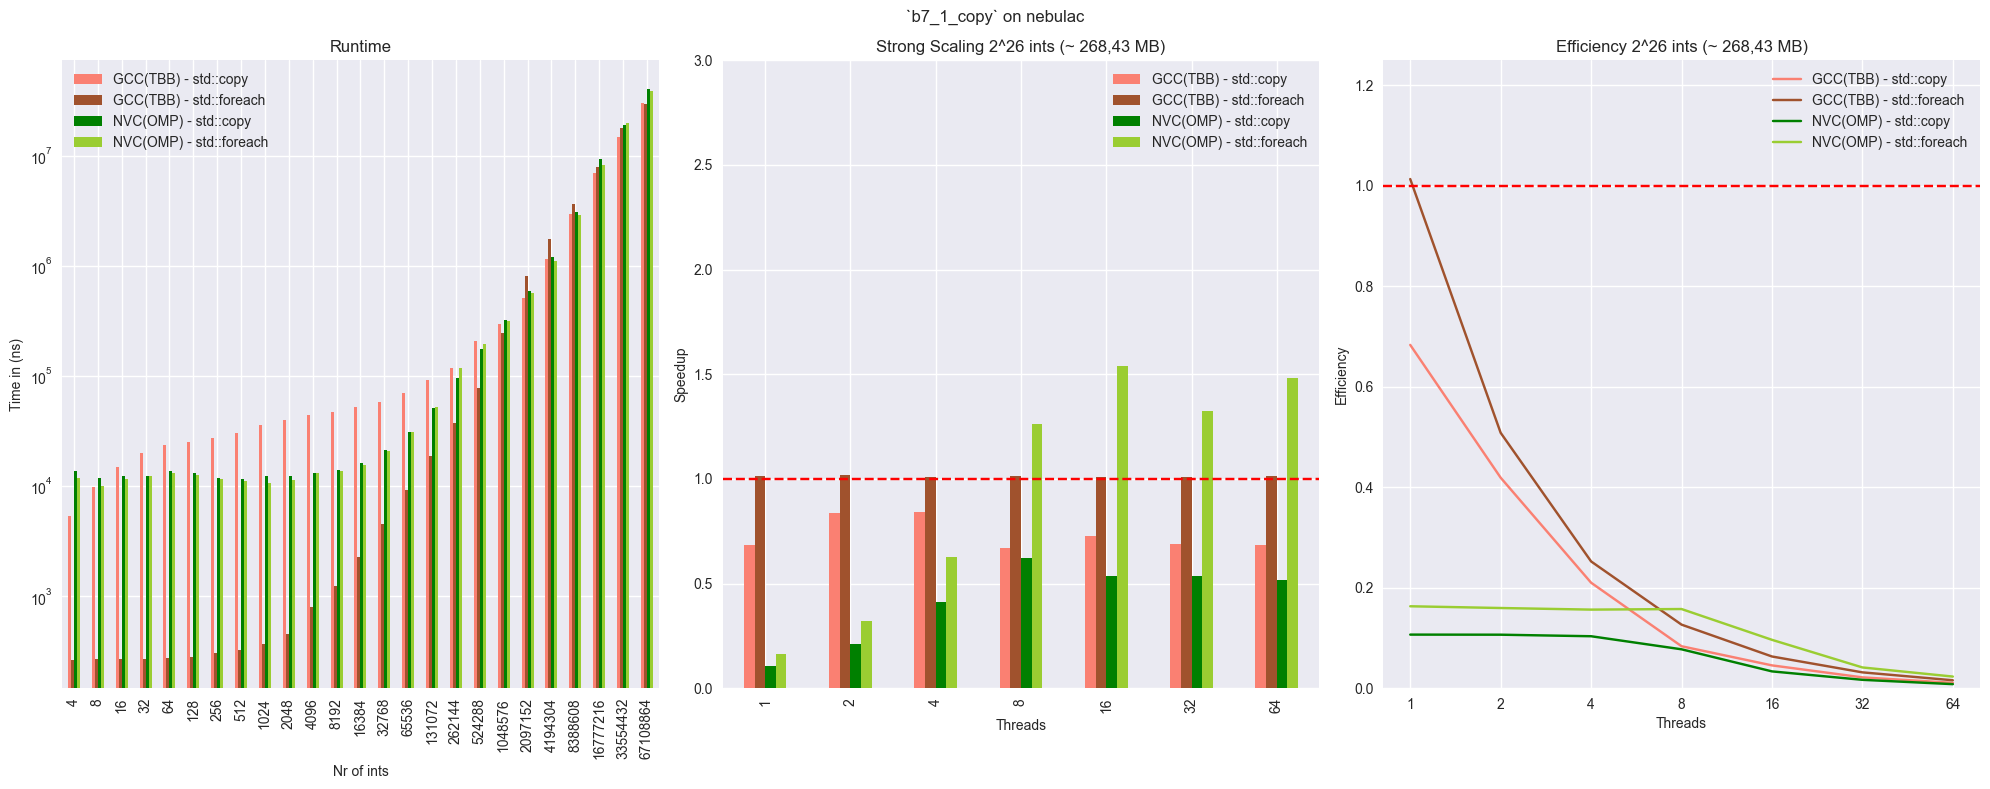

In [436]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_1_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_1_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b7_1_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b7_1_copy` on nebulac")

fig.tight_layout()

plot("`b7_1_copy` nebulac")

## `b7_2` -  all_true

In [437]:
benchmark_names = [
    ("b7_2_all_of_all_true",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_all_true",'std::transform_reduce')
]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_true

Check how the runtime without constraining the threads develops with increasing input size

In [438]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_time_merged = pd.merge(b7_2_time_merged,data[i], on='n')

b7_2_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,5609.29,4,4779.24,56266.9,27379.8
1,9716.45,8,9584.90,47622.3,23801.1
2,14856.70,16,14805.30,50914.4,23213.2
3,19082.00,32,20423.00,51739.3,22998.2
4,23121.70,64,24626.30,56801.3,24876.7
5,25552.40,128,28133.80,50498.4,24903.3
6,27635.60,256,26604.70,48603.0,24545.0
7,31439.80,512,27749.90,48852.9,24106.5
8,35232.20,1024,30975.70,48408.2,24428.0
9,38635.80,2048,34180.10,48637.6,24143.5


### Strong Scaling - copy logic
 
2^26 fixed input size with threads 1-64

In [439]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_strong_scaling_merged = pd.merge(b7_2_strong_scaling_merged,data[i], on='threads')


b7_2_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.037043,0.998791,0.354157,1.029655
1,2,1.895436,1.967071,0.694486,2.020420
2,4,2.634169,2.897410,1.003851,3.964782
3,8,2.077485,2.477194,1.020918,3.035238
4,16,1.880750,2.545525,1.063296,2.953535
5,32,2.213072,2.523548,1.150987,3.921026
6,64,1.884262,2.296624,0.700520,2.453045


In [440]:
## efficiency graph

b7_2_efficiency = b7_2_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_efficiency[f'{compiler_name} - {display_name}'] = b7_2_efficiency[f'{compiler_name} - {display_name}'] / b7_2_efficiency['threads']

b7_2_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.037043,0.998791,0.354157,1.029655
1,2,0.947718,0.983535,0.347243,1.010210
2,4,0.658542,0.724353,0.250963,0.991196
3,8,0.259686,0.309649,0.127615,0.379405
4,16,0.117547,0.159095,0.066456,0.184596
5,32,0.069158,0.078861,0.035968,0.122532
6,64,0.029442,0.035885,0.010946,0.038329


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_13142/3642852530.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


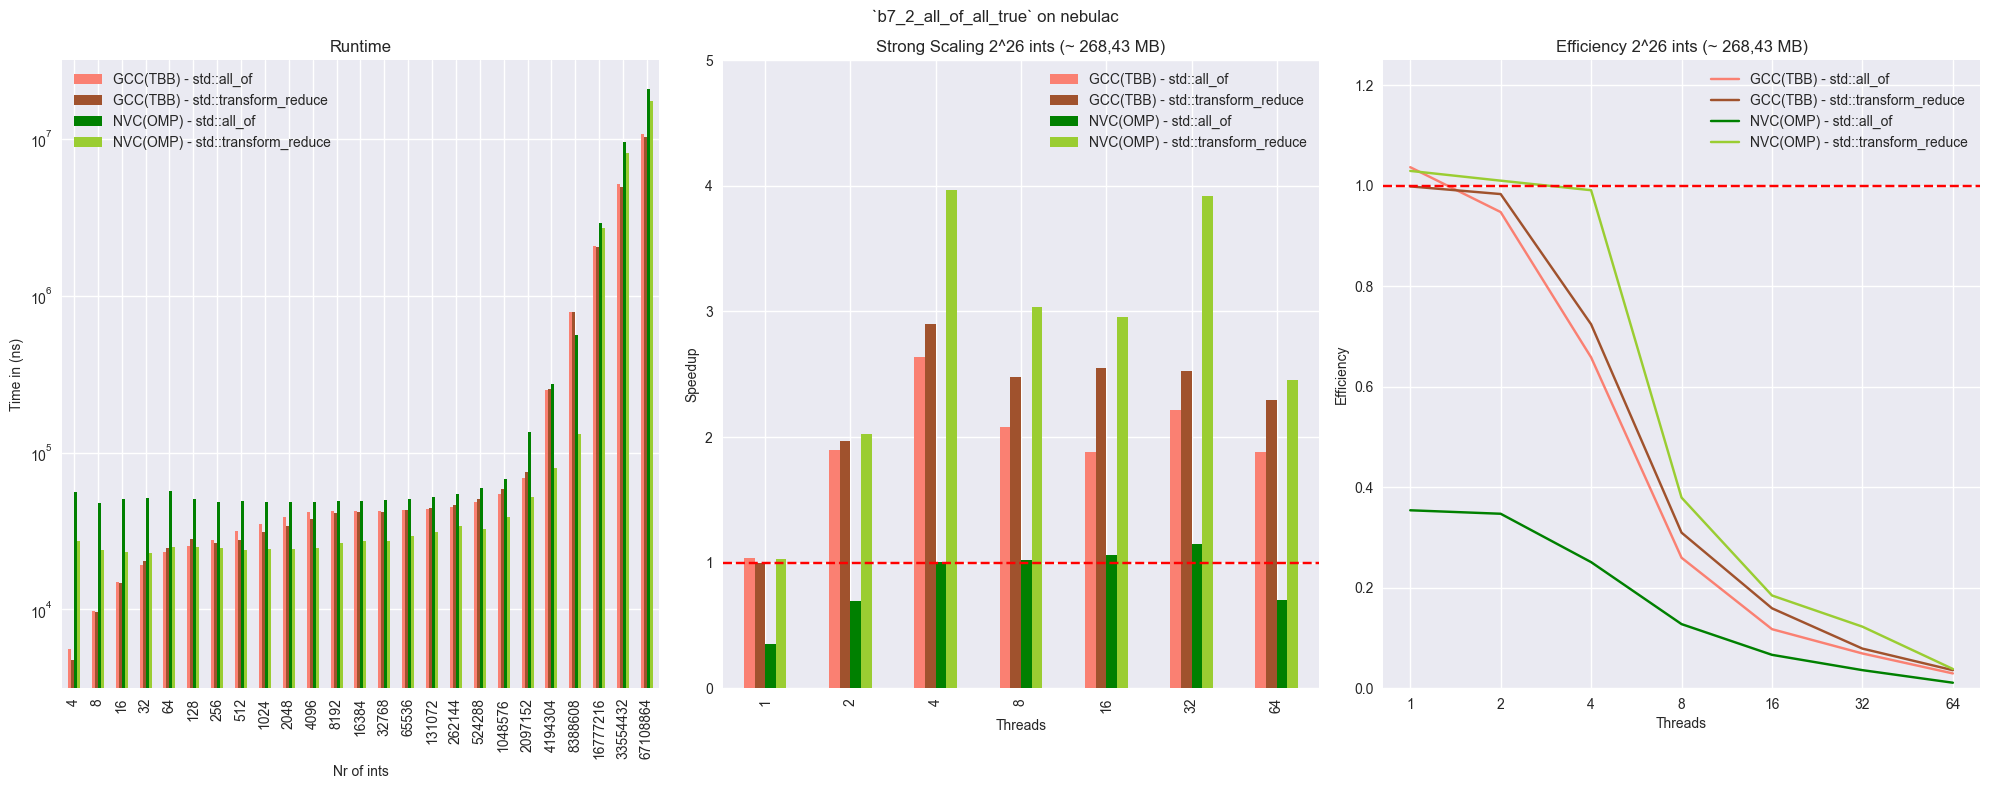

In [441]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b7_2_all_of_all_true` on nebulac")

fig.tight_layout()

plot("`b7_2_all_of_all_true` nebulac")

## `b7_2` -  first_false

In [442]:
benchmark_names = [
    ("b7_2_all_of_first_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_first_false",'std::transform_reduce')
]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - first_false

Check how the runtime without constraining the threads develops with increasing input size

In [443]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_first_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_time_merged = pd.merge(b7_2_first_false_time_merged,data[i], on='n')

b7_2_first_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,5508.46,4,4351.93,58232.0,45316.2
1,8145.25,8,5882.54,43599.4,26074.1
2,10642.20,16,10043.90,42729.2,22481.4
3,12886.50,32,14973.50,46218.3,23396.7
4,15185.70,64,19767.50,45366.8,26533.3
5,17521.10,128,23680.90,45346.9,26582.5
6,19630.30,256,26245.40,45503.0,26470.7
7,19304.30,512,27834.10,45330.5,26387.9
8,20050.50,1024,30590.30,45912.2,26521.9
9,21104.90,2048,34328.40,45216.8,26468.5


### Strong Scaling - first_false
 
2^26 fixed input size with threads 1-64

In [444]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_first_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_strong_scaling_merged = pd.merge(b7_2_first_false_strong_scaling_merged,data[i], on='threads')


b7_2_first_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.278947,1.002328,0.000235,0.490719
1,2,0.057655,1.987661,0.000460,0.989786
2,4,0.025890,3.115559,0.000842,1.897977
3,8,0.015248,3.229925,0.001487,1.611206
4,16,0.013000,2.606454,0.002253,1.379050
5,32,0.012363,2.735006,0.002828,1.321208
6,64,0.011650,2.682118,0.002769,1.265554


In [445]:
## efficiency graph

b7_2_first_false_efficiency = b7_2_first_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_first_false_efficiency['threads']

b7_2_first_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.278947,1.002328,0.000235,0.490719
1,2,0.028828,0.993831,0.000230,0.494893
2,4,0.006473,0.778890,0.000210,0.474494
3,8,0.001906,0.403741,0.000186,0.201401
4,16,0.000813,0.162903,0.000141,0.086191
5,32,0.000386,0.085469,0.000088,0.041288
6,64,0.000182,0.041908,0.000043,0.019774


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_13142/3499337355.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


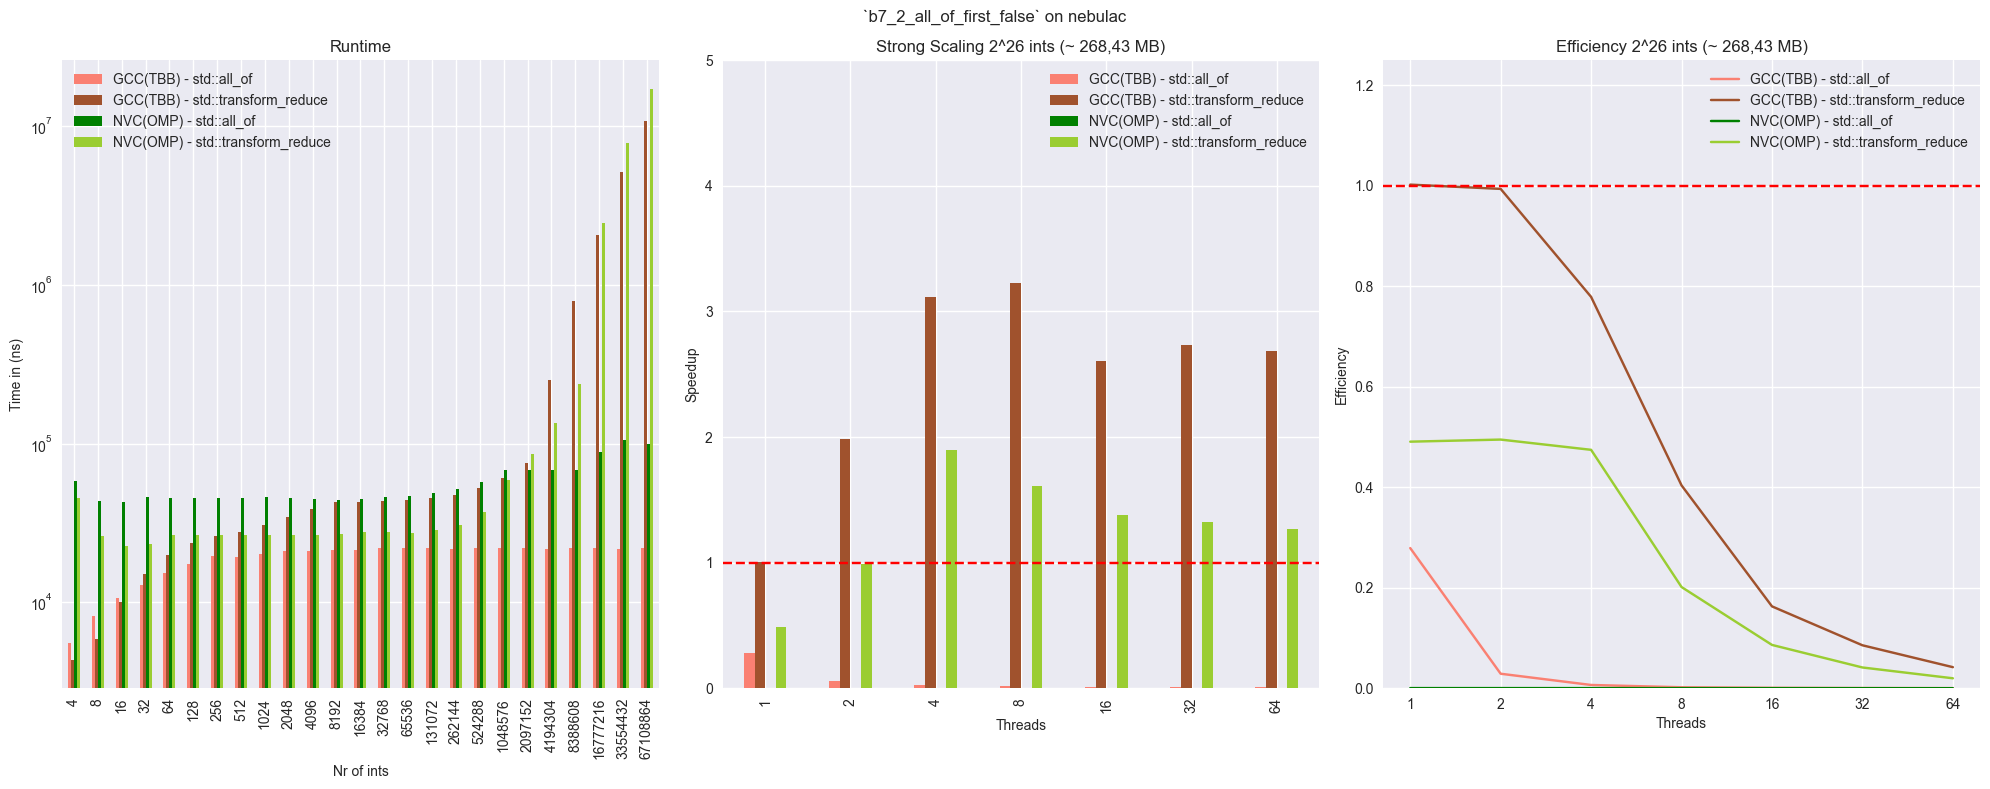

In [446]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_first_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_first_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_first_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b7_2_all_of_first_false` on nebulac")

fig.tight_layout()

plot("`b7_2_all_of_first_false` nebulac")

## `b7_2` -  last_false

In [447]:
benchmark_names = [
    ("b7_2_all_of_last_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_last_false",'std::transform_reduce')
]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - last_false

Check how the runtime without constraining the threads develops with increasing input size

In [448]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_last_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_time_merged = pd.merge(b7_2_last_false_time_merged,data[i], on='n')

b7_2_last_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,5898.24,4,3856.91,67067.0,24521.9
1,12061.10,8,8767.84,51778.4,21386.1
2,17411.00,16,11137.70,47028.5,21747.2
3,23477.50,32,16134.00,47489.1,24017.9
4,27333.70,64,21252.80,49389.2,26707.6
5,29414.90,128,25293.80,48561.4,25234.3
6,30301.30,256,27920.20,51895.8,25411.0
7,30945.80,512,32431.60,48331.0,25306.2
8,32010.10,1024,36361.50,47620.1,25377.3
9,33498.00,2048,40230.70,47003.1,29444.8


### Strong Scaling - last_false
 
2^26 fixed input size with threads 1-64

In [449]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_last_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_strong_scaling_merged = pd.merge(b7_2_last_false_strong_scaling_merged,data[i], on='threads')


b7_2_last_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.006574,0.996559,0.281948,1.001265
1,2,1.917205,2.013003,0.552114,2.012643
2,4,2.842730,3.503177,0.837835,3.951924
3,8,2.193120,2.277491,1.027520,3.270616
4,16,2.749964,3.004645,1.179144,3.145659
5,32,3.172975,3.132435,1.153352,2.743234
6,64,2.675738,2.816195,0.527471,2.861640


In [450]:
## efficiency graph

b7_2_last_false_efficiency = b7_2_last_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_last_false_efficiency['threads']

b7_2_last_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.006574,0.996559,0.281948,1.001265
1,2,0.958603,1.006502,0.276057,1.006322
2,4,0.710682,0.875794,0.209459,0.987981
3,8,0.274140,0.284686,0.128440,0.408827
4,16,0.171873,0.187790,0.073697,0.196604
5,32,0.099155,0.097889,0.036042,0.085726
6,64,0.041808,0.044003,0.008242,0.044713


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_13142/4033080484.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


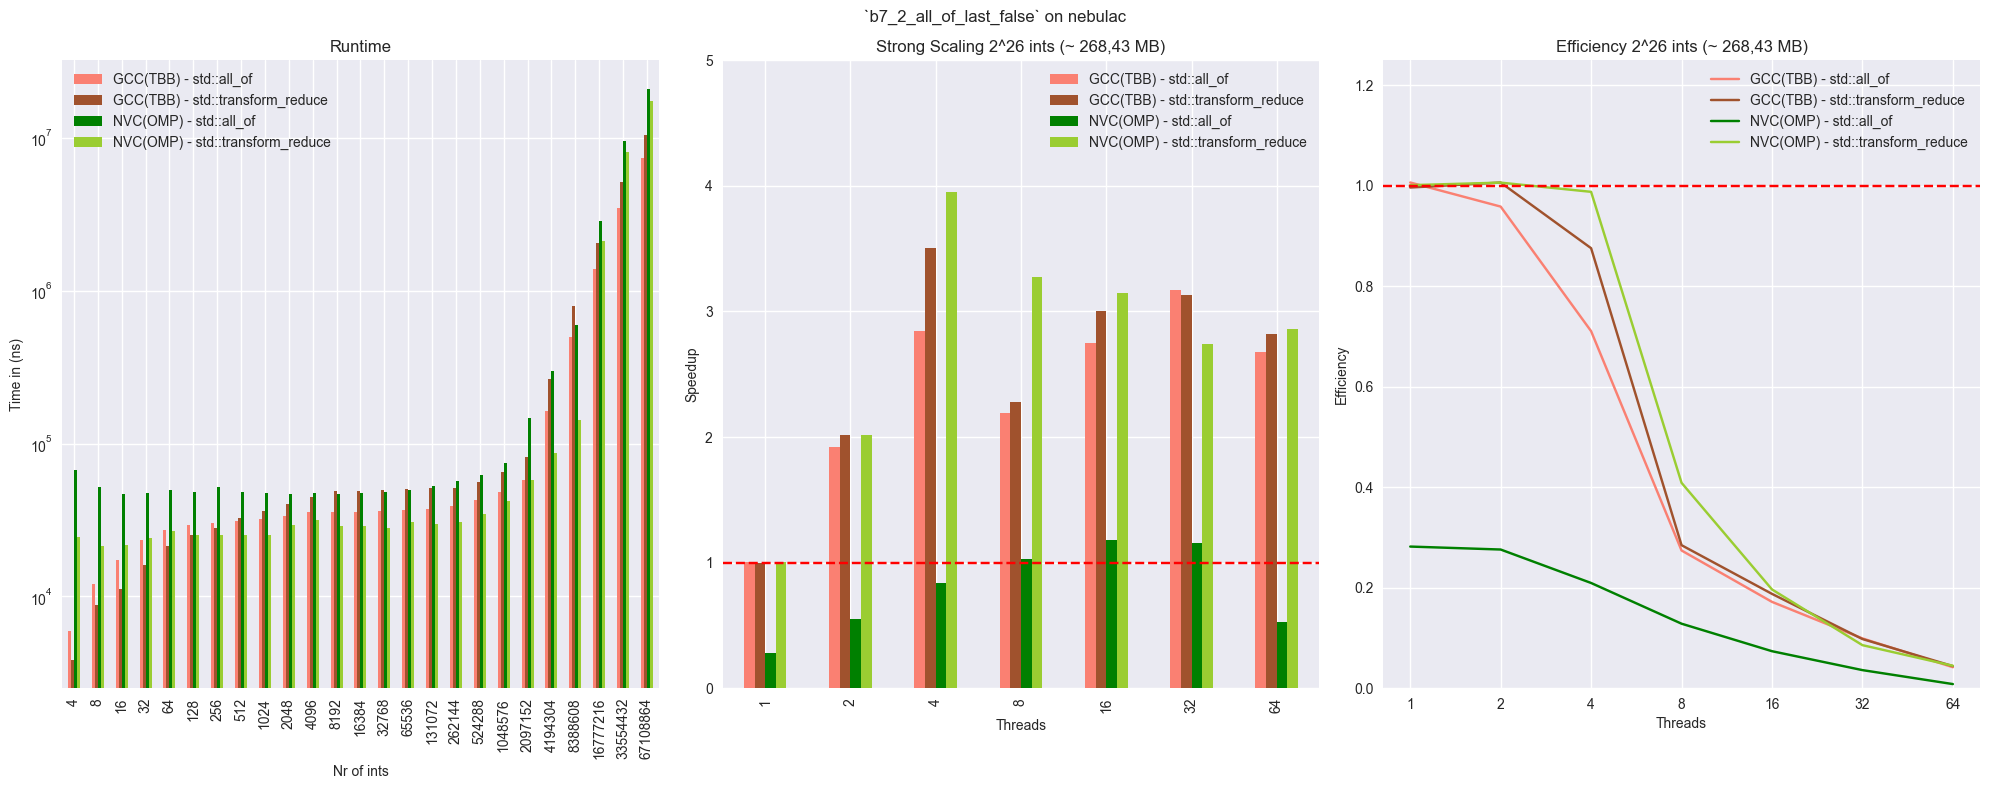

In [451]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_last_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_last_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_last_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b7_2_all_of_last_false` on nebulac")

fig.tight_layout()

plot("`b7_2_all_of_last_false` nebulac")

## `b7_2` -  auto_false

In [452]:
benchmark_names = [
    ("b7_2_all_of_auto_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_auto_false",'std::transform_reduce')
]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - auto_false

Check how the runtime without constraining the threads develops with increasing input size

In [453]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_auto_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_time_merged = pd.merge(b7_2_auto_false_time_merged,data[i], on='n')

b7_2_auto_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,7019.38,4,4448.04,46008.4,51117.3
1,10415.70,8,6020.40,38594.3,23175.4
2,12498.10,16,10843.50,40875.1,20563.9
3,14950.90,32,16991.70,40544.6,22109.8
4,17320.50,64,22694.70,40819.2,23434.7
5,19472.40,128,27693.10,41153.2,23372.6
6,21561.30,256,30100.90,40834.1,23157.5
7,21527.20,512,31477.70,41288.1,23179.6
8,21724.30,1024,34109.30,41758.6,23264.5
9,21710.50,2048,36271.90,42076.4,23182.2


### Strong Scaling - auto_false
 
2^26 fixed input size with threads 1-64

In [454]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_auto_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_strong_scaling_merged = pd.merge(b7_2_auto_false_strong_scaling_merged,data[i], on='threads')


b7_2_auto_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.277014,0.000024,0.001005,21702.438552
1,2,0.076044,0.000048,0.001872,4631.299625
2,4,0.035795,0.000094,0.002777,2393.358405
3,8,0.021340,0.000181,0.004219,1311.131638
4,16,0.013986,0.000334,0.004774,1125.535108
5,32,0.011489,0.000544,0.004564,903.758120
6,64,0.010477,0.000848,0.004091,862.887153


In [455]:
## efficiency graph

b7_2_auto_false_efficiency = b7_2_auto_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_auto_false_efficiency['threads']

b7_2_auto_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.277014,0.000024,0.001005,21702.438552
1,2,0.038022,0.000024,0.000936,2315.649813
2,4,0.008949,0.000024,0.000694,598.339601
3,8,0.002668,0.000023,0.000527,163.891455
4,16,0.000874,0.000021,0.000298,70.345944
5,32,0.000359,0.000017,0.000143,28.242441
6,64,0.000164,0.000013,0.000064,13.482612


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_13142/1599396692.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


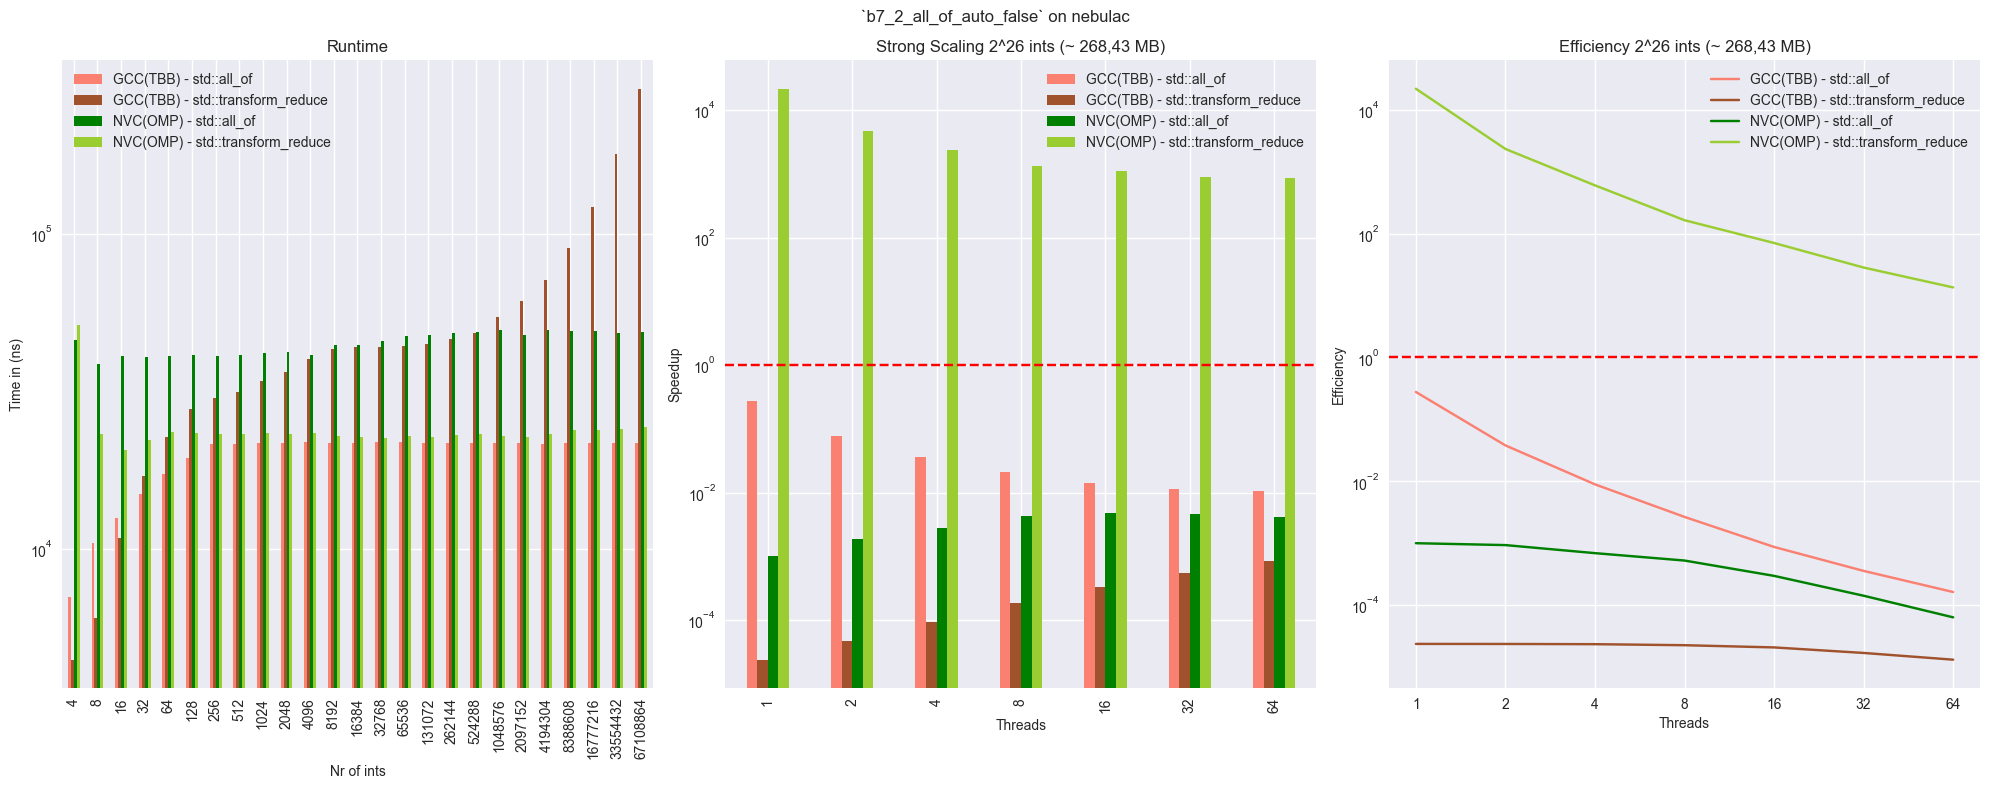

In [456]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_auto_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_auto_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_yscale('log',base=10)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')



# plot efficiency
ax_3 = b7_2_auto_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_yscale('log',base=10)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b7_2_all_of_auto_false` on nebulac")

fig.tight_layout()

plot("`b7_2_all_of_auto_false` nebulac")

## `b7_3` -  all_hit

In [457]:
benchmark_names = [
    ("b7_3_count_if_all_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_all_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_all_hit",'std::for_each')
]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_hit

Check how the runtime without constraining the threads develops with increasing input size

In [458]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_all_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_time_merged = pd.merge(b7_3_all_hit_time_merged,data[i], on='n')

b7_3_all_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,5979.91,4,4442.83,21930.4,33781.7
1,13707.40,8,8540.50,19738.9,22081.2
2,21412.70,16,13851.80,19218.1,20603.7
3,26131.60,32,19474.50,20915.4,21263.7
4,29491.60,64,24151.70,21203.3,27096.4
5,31800.10,128,27917.30,21131.6,26450.5
6,32210.50,256,30218.30,21000.6,24635.7
7,34311.10,512,31309.90,21360.4,23904.3
8,37095.90,1024,32750.70,21644.8,24074.3
9,40691.80,2048,35404.10,21758.5,24152.5


### Strong Scaling - all_hit
 
2^26 fixed input size with threads 1-64

In [459]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_all_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_strong_scaling_merged = pd.merge(b7_3_all_hit_strong_scaling_merged,data[i], on='threads')


b7_3_all_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.014378,0.992811,2.438728,3.654325
1,2,1.858416,2.004224,4.658769,5.771231
2,4,2.508890,3.555146,4.663401,5.868087
3,8,2.216368,3.432703,3.940377,3.245749
4,16,1.923881,2.868029,3.057469,3.106939
5,32,1.991645,3.097563,2.428338,2.744125
6,64,1.765683,3.034886,3.285794,3.692434


In [460]:
## efficiency graph

b7_3_all_hit_efficiency = b7_3_all_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_all_hit_efficiency['threads']

b7_3_all_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.014378,0.992811,2.438728,3.654325
1,2,0.929208,1.002112,2.329384,2.885615
2,4,0.627223,0.888787,1.165850,1.467022
3,8,0.277046,0.429088,0.492547,0.405719
4,16,0.120243,0.179252,0.191092,0.194184
5,32,0.062239,0.096799,0.075886,0.085754
6,64,0.027589,0.047420,0.051341,0.057694


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_13142/4040462002.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


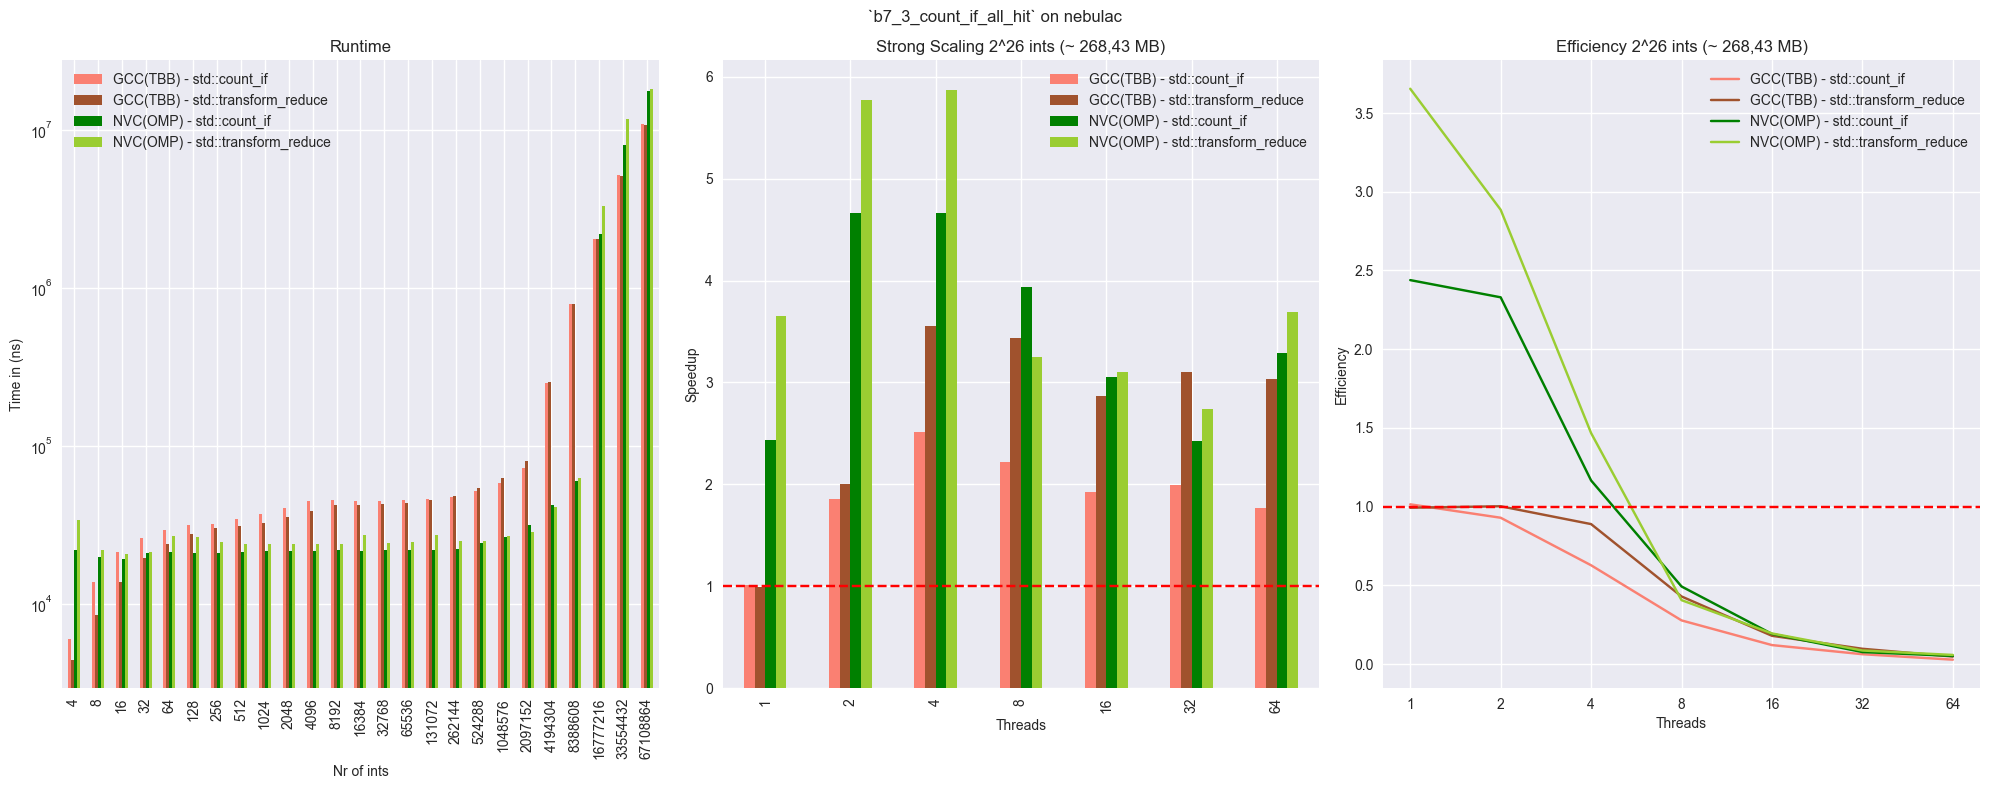

In [461]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_all_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_all_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_all_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b7_3_count_if_all_hit` on nebulac")

fig.tight_layout()

plot("`b7_3_count_if_all_hit` nebulac")

## `b7_3` -  half_hit

In [462]:
benchmark_names = [
    ("b7_3_count_if_half_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_half_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_half_hit",'std::for_each')
]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - half_hit

Check how the runtime without constraining the threads develops with increasing input size

In [463]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_half_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_time_merged = pd.merge(b7_3_half_hit_time_merged,data[i], on='n')

b7_3_half_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,6465.78,4,4245.79,27332.9,50125.9
1,14246.30,8,5848.93,21794.0,23285.5
2,21520.30,16,9941.86,21968.5,21664.0
3,25850.60,32,15024.60,23255.5,22015.4
4,29710.90,64,19660.60,24252.3,25845.5
5,31888.70,128,23574.30,24154.7,23180.4
6,33810.10,256,26237.10,24700.7,22937.1
7,36889.30,512,27735.20,24226.8,22561.5
8,40446.40,1024,30313.80,24153.7,22672.4
9,44837.70,2048,35323.80,23471.5,22903.8


### Strong Scaling - half_hit
 
2^26 fixed input size with threads 1-64

In [464]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_half_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_strong_scaling_merged = pd.merge(b7_3_half_hit_strong_scaling_merged,data[i], on='threads')


b7_3_half_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.047513,0.992016,1.001102,3.389391
1,2,1.962479,2.007750,1.295572,5.610793
2,4,2.572530,2.506560,1.571207,4.664628
3,8,2.269525,3.480035,1.436497,2.969298
4,16,2.162635,3.297928,1.668387,2.779654
5,32,1.994683,3.460264,1.151812,2.713092
6,64,1.936582,3.105472,1.296480,2.637379


In [465]:
## efficiency graph

b7_3_half_hit_efficiency = b7_3_half_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_half_hit_efficiency['threads']

b7_3_half_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.047513,0.992016,1.001102,3.389391
1,2,0.981239,1.003875,0.647786,2.805396
2,4,0.643133,0.626640,0.392802,1.166157
3,8,0.283691,0.435004,0.179562,0.371162
4,16,0.135165,0.206120,0.104274,0.173728
5,32,0.062334,0.108133,0.035994,0.084784
6,64,0.030259,0.048523,0.020257,0.041209


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_13142/3656297349.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


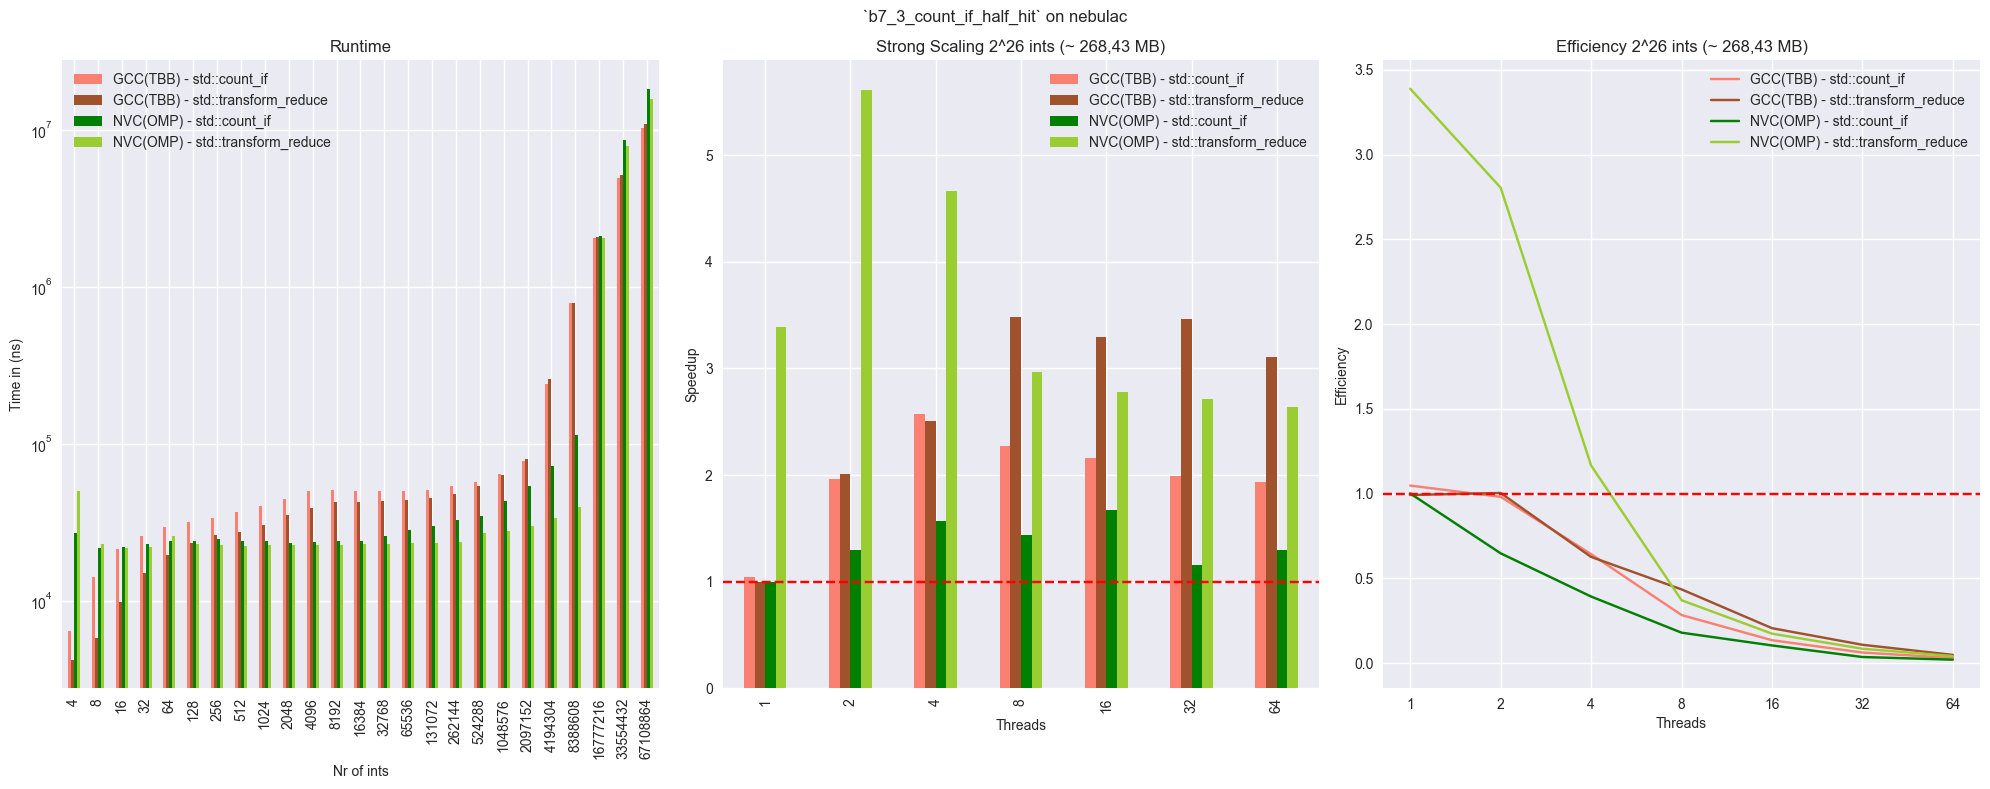

In [466]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_half_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_half_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_half_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b7_3_count_if_half_hit` on nebulac")

fig.tight_layout()

plot("`b7_3_count_if_half_hit` nebulac")

## `b7_3` -  orders_struct

In [467]:
benchmark_names = [
    ("b7_3_count_if_orders_struct",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_orders_struct",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_orders_struct",'std::for_each')
]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - orders_struct

Check how the runtime without constraining the threads develops with increasing input size

In [468]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_orders_struct_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_time_merged = pd.merge(b7_3_orders_struct_time_merged,data[i], on='n')

b7_3_orders_struct_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,6307.13,4,4799.85,29466.3,40542.7
1,11119.30,8,6033.43,22158.3,24411.5
2,16566.00,16,10180.10,21983.6,22216.0
3,21494.30,32,16305.50,22869.9,23609.9
4,25359.60,64,22045.10,22876.7,24641.1
5,27480.20,128,24227.80,22818.1,24612.6
6,29457.20,256,26631.50,22897.4,24838.2
7,32348.00,512,28406.10,22884.6,24753.2
8,36663.70,1024,31437.40,22724.4,24720.8
9,40201.70,2048,34774.10,23985.5,24990.6


### Strong Scaling - orders_struct
 
2^26 fixed input size with threads 1-64

In [469]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_orders_struct_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_strong_scaling_merged = pd.merge(b7_3_orders_struct_strong_scaling_merged,data[i], on='threads')


b7_3_orders_struct_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.985755,0.996283,1.654641,1.710454
1,2,1.912015,1.998575,2.495382,3.144278
2,4,2.070678,3.099578,3.990441,3.546468
3,8,1.755473,2.440370,2.153438,2.129146
4,16,1.890527,2.355895,1.578551,1.768117
5,32,2.022155,2.533010,2.449508,1.942310
6,64,2.018714,2.374986,2.012938,2.019050


In [470]:
## efficiency graph

b7_3_orders_struct_efficiency = b7_3_orders_struct_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] = b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] / b7_3_orders_struct_efficiency['threads']

b7_3_orders_struct_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.985755,0.996283,1.654641,1.710454
1,2,0.956008,0.999287,1.247691,1.572139
2,4,0.517669,0.774894,0.997610,0.886617
3,8,0.219434,0.305046,0.269180,0.266143
4,16,0.118158,0.147243,0.098659,0.110507
5,32,0.063192,0.079157,0.076547,0.060697
6,64,0.031542,0.037109,0.031452,0.031548


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_13142/1868180074.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


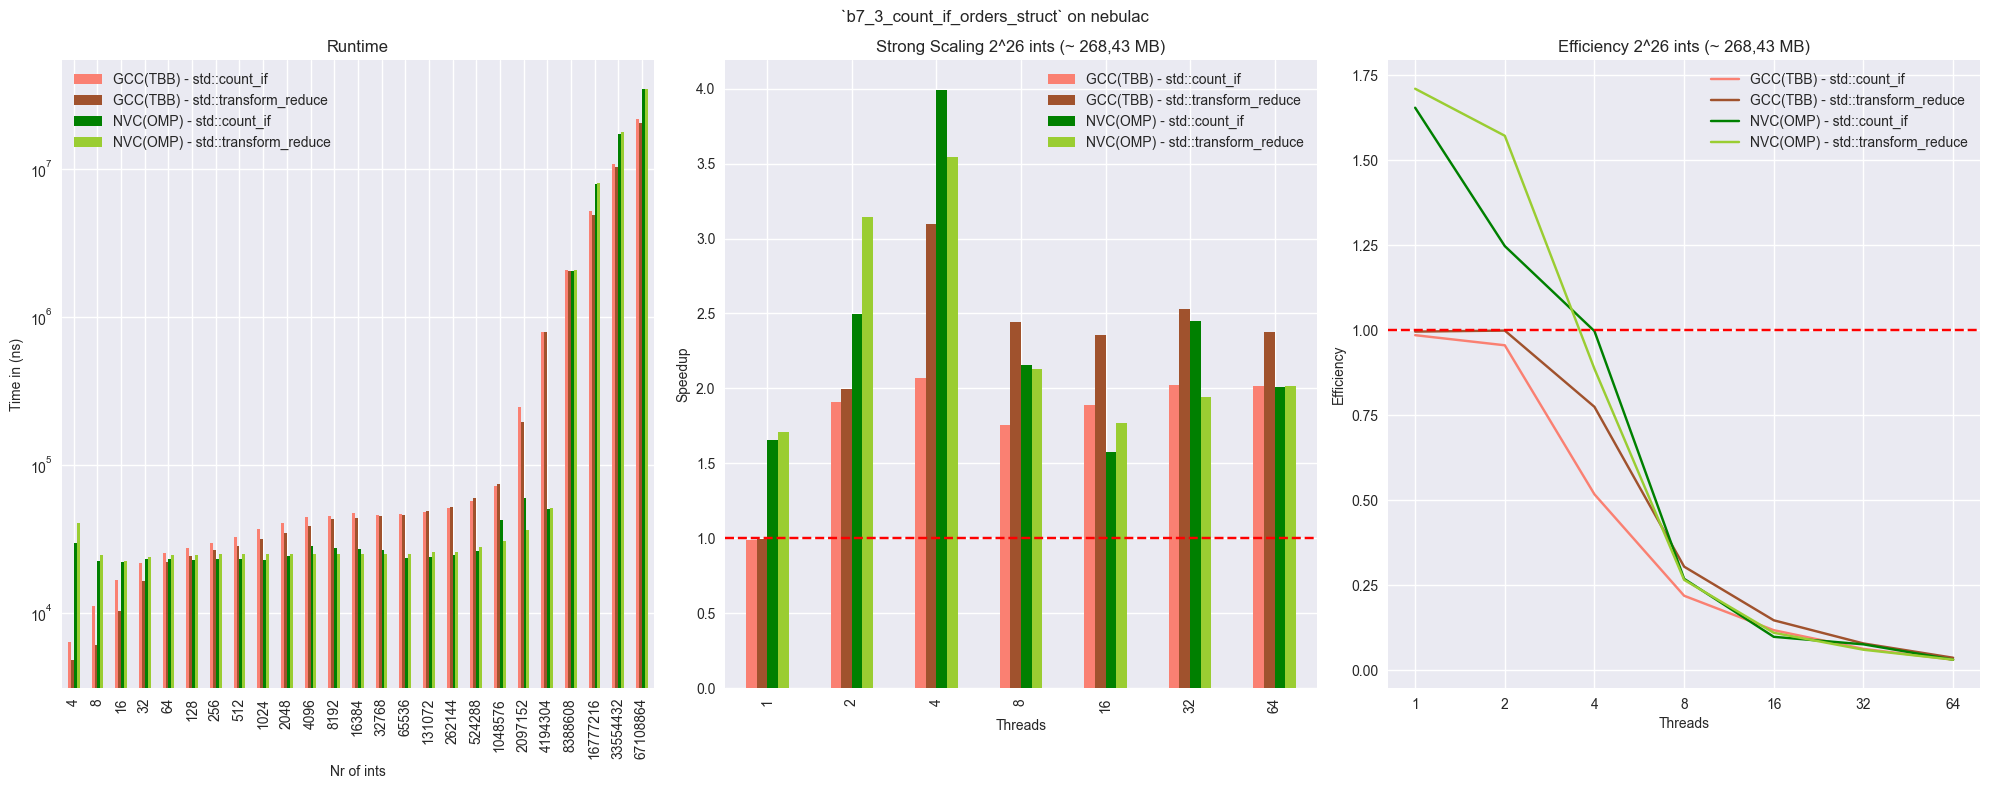

In [471]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_orders_struct_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_orders_struct_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_orders_struct_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b7_3_count_if_orders_struct` on nebulac")

fig.tight_layout()

plot("`b7_3_count_if_orders_struct` nebulac")

## `b7_4` - stencil transform 

In [472]:
benchmark_names = [
    ("b7_4_stencil_transform_number_to_neightbours_stdev",'std::transform'),
    ("b7_4_stencil_for_each_to_neightbours_stdev",'std::for_each')
]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [473]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_4_stencil_time_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_time_merged = pd.merge(b7_4_stencil_time_merged,data[i], on='n')

b7_4_stencil_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,3674.22,4,4407.87,13634.8,14347.7
1,8473.92,8,11632.30,12770.9,11917.1
2,14944.60,16,19509.60,12978.6,10259.8
3,20556.10,32,24444.70,12594.9,11588.7
4,24042.10,64,27328.40,13361.0,13053.9
5,26015.60,128,28780.40,13240.4,12370.1
6,28701.10,256,30401.20,12806.3,12568.6
7,32112.50,512,33284.40,13772.3,12501.0
8,36510.00,1024,36706.60,13703.8,15356.0
9,41277.60,2048,41116.70,14674.0,14632.2


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [474]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_4_stencil_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_strong_scaling_merged = pd.merge(b7_4_stencil_strong_scaling_merged,data[i], on='threads')


b7_4_stencil_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,1.017199,0.947792,0.318960,0.536430
1,2,2.030657,1.892440,0.636967,1.073271
2,4,4.009130,3.628217,1.217124,2.101664
3,8,4.987895,4.906599,1.392756,3.282935
4,16,4.599099,4.037703,1.363101,3.142167
5,32,4.566229,4.547884,1.272449,3.372622
6,64,4.384947,4.300545,1.197133,3.105396


In [475]:
## efficiency graph

b7_4_stencil_efficiency = b7_4_stencil_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] = b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] / b7_4_stencil_efficiency['threads']

b7_4_stencil_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,1.017199,0.947792,0.318960,0.536430
1,2,1.015329,0.946220,0.318483,0.536636
2,4,1.002282,0.907054,0.304281,0.525416
3,8,0.623487,0.613325,0.174095,0.410367
4,16,0.287444,0.252356,0.085194,0.196385
5,32,0.142695,0.142121,0.039764,0.105394
6,64,0.068515,0.067196,0.018705,0.048522


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_13142/3890372529.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


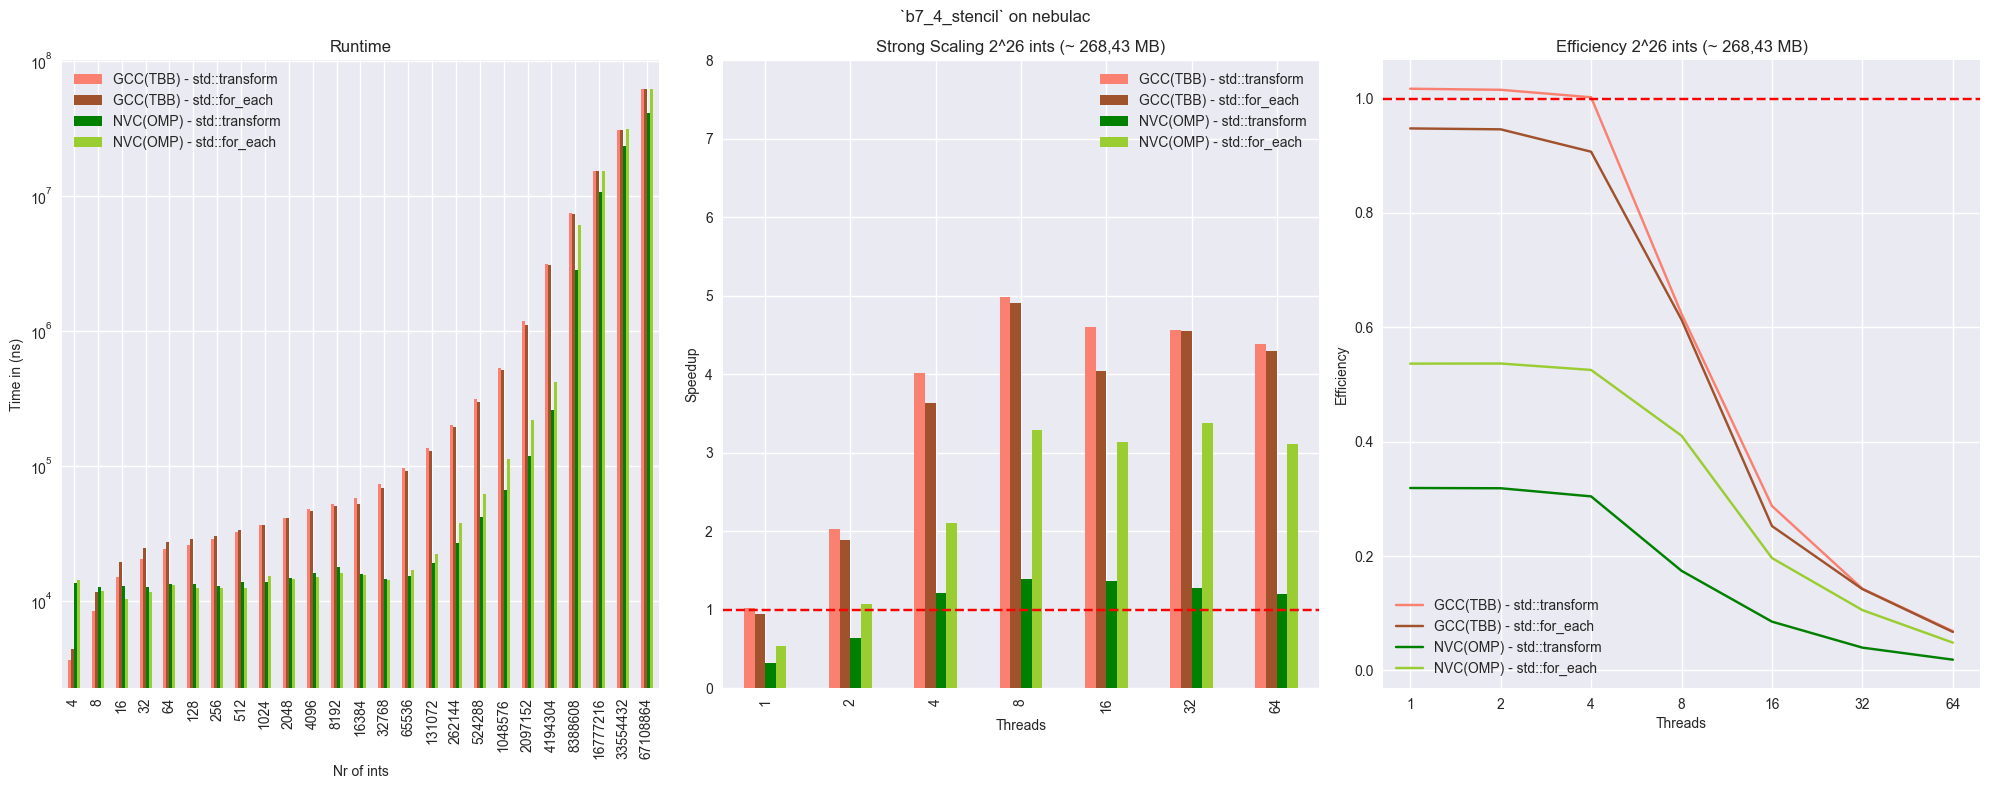

In [476]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_4_stencil_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_4_stencil_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')

ax_2.set_ylim(0,8)



# plot efficiency
ax_3 = b7_4_stencil_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b7_4_stencil` on nebulac")

fig.tight_layout()

plot("`b7_4_stencil` nebulac")

## `b7_5` - Scalar Transform 

In [484]:
benchmark_names = [
    ("b7_5_scalar_transform_number",'std::transform'),
    ("b7_5_scalar_for_each",'std::for_each')
]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [485]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_5_scalar_transform_time_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_time_merged = pd.merge(b7_5_scalar_transform_time_merged,data[i], on='n')

b7_5_scalar_transform_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,5430.10,4,6623.75,15903.9,11722.1
1,9488.74,8,14727.80,12209.2,11341.3
2,14790.30,16,20401.40,12274.8,11581.1
3,20105.90,32,24627.80,13216.9,11985.1
4,23948.10,64,27512.50,13701.2,14871.1
5,28818.20,128,26632.80,12933.6,14064.9
6,33216.70,256,28764.30,14315.7,14750.5
7,35417.30,512,32754.30,13247.7,16103.1
8,37861.90,1024,35673.70,12897.3,14566.5
9,41752.90,2048,39465.40,12905.2,15588.2


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [479]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_5_scalar_transform_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_strong_scaling_merged = pd.merge(b7_5_scalar_transform_strong_scaling_merged,data[i], on='threads')


b7_5_scalar_transform_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.995212,0.949098,0.235531,0.220724
1,2,1.262877,1.504936,0.470170,0.415031
2,4,1.337018,1.967791,0.913458,0.864561
3,8,1.176935,1.950966,1.335049,1.608793
4,16,1.112132,1.896926,1.332234,1.590379
5,32,1.089202,1.880160,1.446501,1.786201
6,64,1.372043,1.619253,1.329240,1.555793


In [480]:
## efficiency graph

b7_5_scalar_transform_efficiency = b7_5_scalar_transform_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] = b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] / b7_5_scalar_transform_efficiency['threads']

b7_5_scalar_transform_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.995212,0.949098,0.235531,0.220724
1,2,0.631438,0.752468,0.235085,0.207516
2,4,0.334254,0.491948,0.228365,0.216140
3,8,0.147117,0.243871,0.166881,0.201099
4,16,0.069508,0.118558,0.083265,0.099399
5,32,0.034038,0.058755,0.045203,0.055819
6,64,0.021438,0.025301,0.020769,0.024309


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_13142/1535273462.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


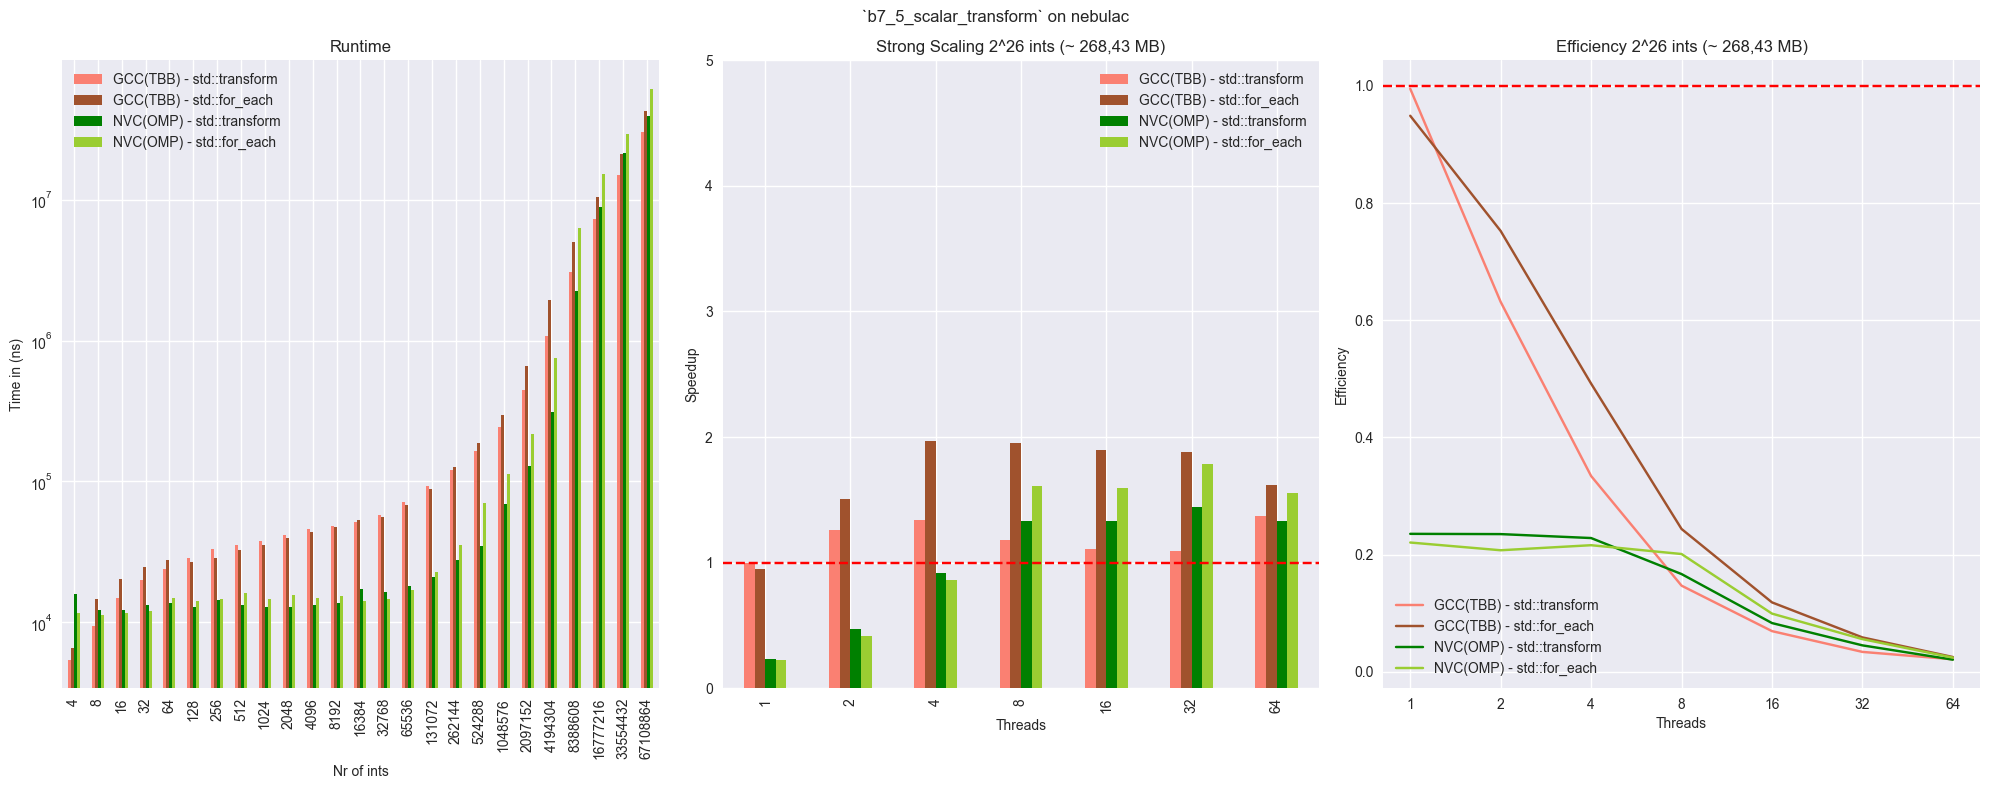

In [483]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_5_scalar_transform_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_5_scalar_transform_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
ax_2.set_ylim(0,5)




# plot efficiency
ax_3 = b7_5_scalar_transform_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b7_5_scalar_transform` on nebulac")

fig.tight_layout()

plot("`b7_5_scalar_transform` nebulac")

## `b7_6` - Serial vs direct call

In [486]:
benchmark_names = [
    ("b7_6_transform_reduce",'std::transform_reduce'),
    ("b7_6_serial_transform_reduce",'serial')
]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [487]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_6_transform_reduce_vs_serial_time_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_time_merged = pd.merge(b7_6_transform_reduce_vs_serial_time_merged,data[i], on='n')

b7_6_transform_reduce_vs_serial_time_merged

,GCC(TBB) - std::transform_reduce,n,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,4722.38,4,9.748080e+03,45824.5,63328.4
1,8665.40,8,1.602070e+04,22987.5,36187.7
2,14481.20,16,2.584940e+04,20744.6,33474.5
3,20207.30,32,3.564080e+04,22415.8,35034.1
4,24576.00,64,4.415380e+04,21631.0,36916.4
5,27750.40,128,5.311150e+04,22065.9,36316.8
6,29908.10,256,5.719450e+04,22174.7,36830.6
7,30738.30,512,6.409050e+04,22265.6,38040.5
8,32538.80,1024,6.992430e+04,22299.1,39864.7
9,35384.40,2048,8.066920e+04,22066.5,46031.2


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [488]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_6_transform_reduce_vs_serial_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_strong_scaling_merged = pd.merge(b7_6_transform_reduce_vs_serial_strong_scaling_merged,data[i], on='threads')


b7_6_transform_reduce_vs_serial_strong_scaling_merged

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,1.009437,0.994814,1.058475,0.556308
1,2,1.541049,1.303599,2.124828,0.977658
2,4,2.161550,1.349583,2.027716,1.370849
3,8,2.236249,1.172713,2.174562,1.348859
4,16,2.026358,1.220202,2.012258,1.266460
5,32,1.796087,1.116050,1.909044,1.115870
6,64,1.718764,1.020835,1.397653,0.912929


In [489]:
## efficiency graph

b7_6_transform_reduce_vs_serial_efficiency = b7_6_transform_reduce_vs_serial_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] = b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] / b7_6_transform_reduce_vs_serial_efficiency['threads']

b7_6_transform_reduce_vs_serial_efficiency

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,1.009437,0.994814,1.058475,0.556308
1,2,0.770525,0.651799,1.062414,0.488829
2,4,0.540388,0.337396,0.506929,0.342712
3,8,0.279531,0.146589,0.271820,0.168607
4,16,0.126647,0.076263,0.125766,0.079154
5,32,0.056128,0.034877,0.059658,0.034871
6,64,0.026856,0.015951,0.021838,0.014265


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_13142/3098209763.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


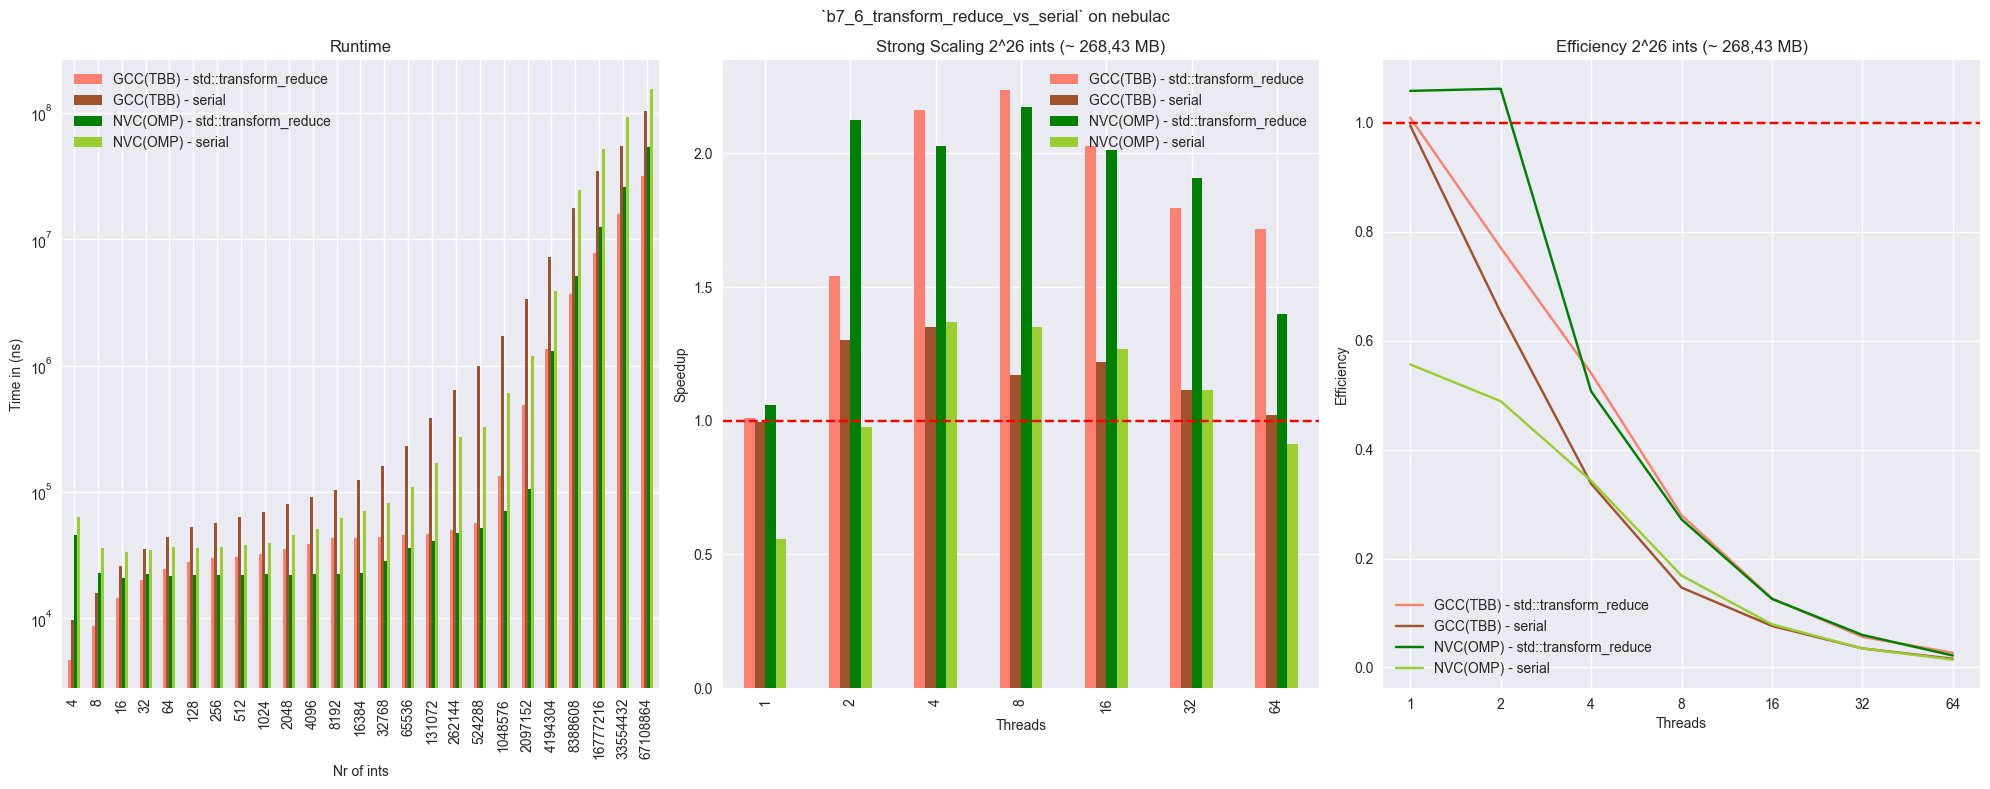

In [490]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_6_transform_reduce_vs_serial_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_6_transform_reduce_vs_serial_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_6_transform_reduce_vs_serial_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b7_6_transform_reduce_vs_serial` on nebulac")

fig.tight_layout()

plot("`b7_6_transform_reduce_vs_serial` nebulac")

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

TODO

In [482]:
# calc pp_metrics


## Findings for H7

### XXX

### General


### GPU Findings


### Hypothesis Findings


